# Importing Libraries

In [133]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Loading Data

In [134]:
data_raw =   pd.read_csv("AMZN.csv")
data_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [135]:
data_raw = data_raw[['Date', 'Close']]

In [136]:
data_raw.head()

,Date,Close
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083


In [137]:
data_raw['Date'] = pd.to_datetime(data_raw['Date'])

# Plotting Graph

/tmp/ipykernel_4522/1096746770.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


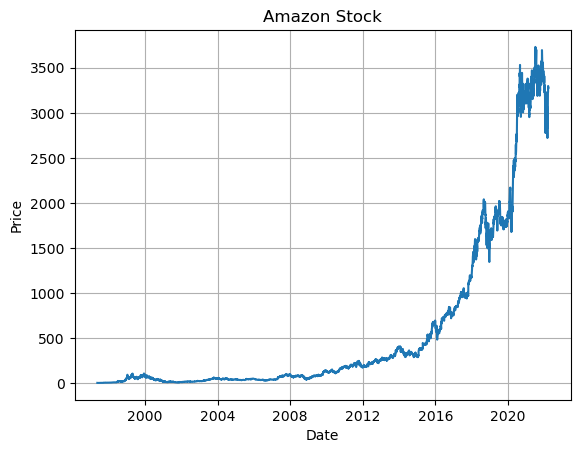

In [138]:
fig, ax = plt.subplots(1, 1)
ax.plot(data_raw['Date'], data_raw['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Amazon Stock')
ax.grid(visible=True)
fig.show()

# Splitting Data

In [139]:
def split_data(data, lookback):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_raw['Close'] = scaler.fit_transform(data_raw['Close'].values.reshape(-1,1))
    data = np.array(data)
    final_data = []

    for i in range(len(data) - lookback):
        final_data.append(data[i:i+lookback+1])
    
    data = np.array(final_data)

    test_size = int(np.round(0.2 * data.shape[0]))
    train_size = data.shape[0] - test_size

    x_train = data[:train_size, :-1]
    x_test = data[train_size:, :-1]
    y_train = data[:train_size, -1]
    y_test = data[train_size:, -1]

    return((x_train, x_test, y_train ,y_test))

In [140]:
x_train, x_test, y_train, y_test = split_data(data_raw['Close'], 7)

In [141]:
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [142]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dense = nn.Linear(hidden_size, output_size)

        nn.ModuleList([self.lstm, self.dense])
    
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.dense(out)
        return(out)

In [143]:
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

In [144]:
model = LSTM(7, 32, 1, 2).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [145]:
def train(model, loss_fn, optimizer, x_train, y_train):
    x, y = x_train.to(device), y_train.to(device)

    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return(loss.item())

In [146]:
epochs = 100
for epoch in range(epochs):
    train(model, loss_fn, optimizer, x_train, y_train)